## Exploratory Data Analysis: Genres

The type of movies that people deem popular today should be different from the movies of the past. With the assumption that genres trend over the years, we will explore how genres can play a part into Net Income and how the distribution of popular movies have changed.

### Libraries to Import

In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import seaborn as sns
sns.set_palette("muted")
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import linregress

### Import Data

In [2]:
df = pd.read_csv('../zippedData/combined.csv',index_col=0)

### Defining Functions

In [3]:
def genre_counter(dataframe):
    '''
    Returns a dictionary of counts by iterating over dataframe['genre_list'].
    '''
    m = {}
    
    for i in dataframe['genre_list']:
        for x in i:
            if x not in m:
                m[x] = 1
            else:
                m[x] += 1
    
    sorted_m = {k: v for k,v in sorted(m.items(), key=lambda item: item[1], reverse=True)}
    
    return sorted_m

In [4]:
def cleaned_genre(dataframe):
    '''
    Returns dataframe with genre dummy columns.
    Genres Counted:['Horror', 'Mystery', 'Thriller', 'Action', 'Adventure', 'Western',
                    'Biography', 'Drama', 'History', 'War', 'Comedy', 'Romance',
                    'Family', 'Fantasy', 'Sci-Fi', 'Crime', 'Music', 'Sport', 'Musical', 'Animation']
    '''
    dataframe.dropna(subset=['genre'],axis=0,inplace=True)                               #drop rows with missing genre
    dataframe.reset_index(drop=True,inplace=True)                                        #need to reset_index before we select drop
    
    dataframe.drop(dataframe[dataframe['genre'].str.contains('See All')].index,axis=0,inplace=True)    #drop rows with genre containing 'Adult' or 'See All'
    dataframe.drop(dataframe[dataframe['genre'].str.contains('Adult')].index,axis=0,inplace=True)      #7 rows with genre containing 'Adult' or 'See All'
    dataframe.reset_index(drop=True,inplace=True)
    
    _list = []
    for i in dataframe['genre']:            #genre column contains list-like strings
        _list.append(ast.literal_eval(i))   #ast can convert these strings into actual lists
    
    dataframe['genre_list'] = _list
    
    m = genre_counter(dataframe)      # m will return dict- key(genre) with value(count)
    genre_category = list(m.keys())
    
    for i in genre_category:   #creating dummy variables with 0
        dataframe[i] = 0       #
    
    print('iterating over 18288 rows')
    for i, x in tqdm(enumerate(dataframe['genre_list'])):
        for each in x:
            dataframe.loc[i, each] = 1
    print('done')
    
    return dataframe

In [5]:
def cleaned_gross_minus_budget(dataframe):
    '''
    Returns cleaned dataframe by: dropping rows with missing 'budget' and 'worldwide-gross', 
    creating new column for 'gross_minus_budget' representing net profits.
    '''
    _df = cleaned_genre(dataframe)   # Make a copy of the dataframe.
    combined = _df.copy()
    
    combined['worldwide_gross'] = combined['worldwide_gross'].str.strip('$')        # Remove $ and commas for...
    combined['worldwide_gross'] = combined['worldwide_gross'].str.replace(',', '')  # worldwide_gross, 
                                                                                    #
    combined['budget'] = combined['budget'].str.strip('$')                          # budget,
    combined['budget'] = combined['budget'].str.replace(',', '')                    #
                                                                                    #
    combined['gross_usa'] = combined['gross_usa'].str.strip('$')                    # and gross_usa.
    combined['gross_usa'] = combined['gross_usa'].str.replace(',', '')              #
    
    
    combined = combined[~combined['budget'].astype(str).str.startswith('SEK')] # Format is redefine the column with all
    combined = combined[~combined['budget'].astype(str).str.startswith('NOK')] # entries EXCEPT where the entry starts
    combined = combined[~combined['budget'].astype(str).str.startswith('KRW')] # with the specified currency string.
    combined = combined[~combined['budget'].astype(str).str.startswith('SGD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('THB')]
    combined = combined[~combined['budget'].astype(str).str.startswith('JPY')]
    combined = combined[~combined['budget'].astype(str).str.startswith('HUF')]
    combined = combined[~combined['budget'].astype(str).str.startswith('INR')]
    combined = combined[~combined['budget'].astype(str).str.startswith('GBP')]
    combined = combined[~combined['budget'].astype(str).str.startswith('HKD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('FRF')]
    combined = combined[~combined['budget'].astype(str).str.startswith('EUR')]
    combined = combined[~combined['budget'].astype(str).str.startswith('FIM')]
    combined = combined[~combined['budget'].astype(str).str.startswith('DEM')]
    combined = combined[~combined['budget'].astype(str).str.startswith('DKK')]
    combined = combined[~combined['budget'].astype(str).str.startswith('CAD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('ESP')]
    combined = combined[~combined['budget'].astype(str).str.startswith('AUD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('BEF')]
    combined = combined[~combined['budget'].astype(str).str.startswith('CNY')]
    combined = combined[~combined['budget'].astype(str).str.startswith('ATS')]
    combined = combined[~combined['budget'].astype(str).str.startswith('BRL')]
    combined = combined[~combined['budget'].astype(str).str.startswith('BRL')]
    combined = combined[~combined['budget'].astype(str).str.startswith('ITL')]
    combined = combined[~combined['budget'].astype(str).str.startswith('RUR')]
    combined = combined[~combined['budget'].astype(str).str.startswith('IEP')]
    combined = combined[~combined['budget'].astype(str).str.startswith('TRL')]
    
    _albert = combined.dropna(subset=['budget','worldwide_gross'],axis=0).copy()   # Drop missing values.
    _albert['budget'] = _albert['budget'].astype('int64')                          # Recast budget as int64.
    _albert['worldwide_gross'] = _albert['worldwide_gross'].astype('int64')        # Recast worldwide_gross as int64.
    
    _albert['gross_minus_budget'] = _albert['worldwide_gross'] - _albert['budget'] # New column as revenue - budget.
    
    print('dropped 11889 rows. final shape: ',_albert.shape)
    return _albert

In [6]:
def find_linregress_slope_dist(dataframe):
    '''
    x = years, y = percentage of movies that contain genre
    Returns a list of tuples of (dist, genre).
    ex: [(0.005,Thriller),(0.004,Drama)...]
    '''
    m = genre_counter(dataframe)
    genre_category = list(m.keys())
    
    _albert = []                                                          # Create empty list.
    for i in genre_category:                                              # For each genre...
        _sample_df = dataframe.groupby(['year'])[i].mean().reset_index()  # get dist of genre in that year
        _linregress = linregress(_sample_df['year'], _sample_df[i])[0]    # get the slope
        _albert.append((_linregress,i))                                   # append slope and genre.
    
    _albert.sort(key = lambda x: x[0], reverse = True)
    return _albert

In [7]:
def plot_genre_distribution(m):
    plt.figure(figsize=(20,10))
    plt.bar(list(m.keys()), m.values())
    plt.ylabel('Count')
    plt.xlabel('Genres')
    plt.title('Overall Genre Distribution')
    sns.despine()
    plt.show()

##### Assigning _genre to be dataframe containing genre dummy variables </br> Assigning m to be a dictionary of genres and total counts per genre

In [8]:
_genre = cleaned_genre(df)

iterating over 18288 rows


18288it [00:22, 828.96it/s]


done


In [9]:
m = genre_counter(_genre)

#### Overall Genre Distribution
##### Important: 
>The total count pertains to the total number of genre observed </br> For example, a (Romance, Comedy) movie will add 1 count to each Romance and Comedy </br> 

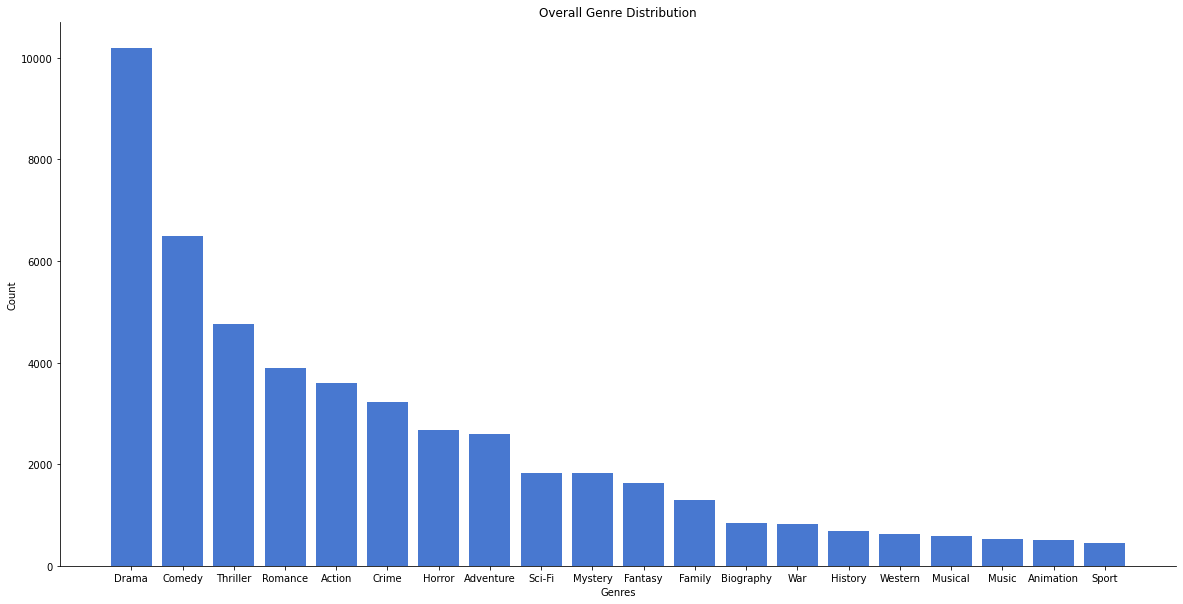

In [10]:
plot_genre_distribution(m)

### Insights:

The distribution comes from the 18288 movies; approximately 300/year from 1960-2020(61 years). The most common genre that appears is 'Drama' while the least appeared is 'Sport'.

### Genre Popularity over Time

In [11]:
def plot_top_worst_dist(dataframe):
    
    _linregress = find_linregress_slope_dist(dataframe) # Use function to find slope of frequency for genre.

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10))     # Create figure with subplots.

    ax_1 = axes[0]
    _df = dataframe.groupby(['year'])[_linregress[0][1]].mean()   # Select data.
    sns.lineplot(x=list(_df.index), y=_df.values, ax= ax_1)        # Plot with x and y.
    
    ax_1.set_ylabel('Distribution')                               # Set x-axis label.
    ax_1.set_xlabel('Year')                                       # Set y-axis label.
    ax_1.set_title('Largest Positive Change: '+_linregress[0][1]) # Set Axis title.
    ax_1.set_ylim(0,0.7)                                          # Set range of y values. 

    ax_2 = axes[1]                                                # Same as Axis[0]
    _df = dataframe.groupby(['year'])[_linregress[-1][1]].mean()
    sns.lineplot(x=list(_df.index), y=_df.values, ax= ax_2)
    
    ax_2.set_ylabel('Distribution')
    ax_2.set_xlabel('Year')
    ax_2.set_title('Largest Negative Change: '+_linregress[-1][1])
    ax_2.set_ylim(0,0.7)

#### Largest Positive Change vs Largest Negative Change


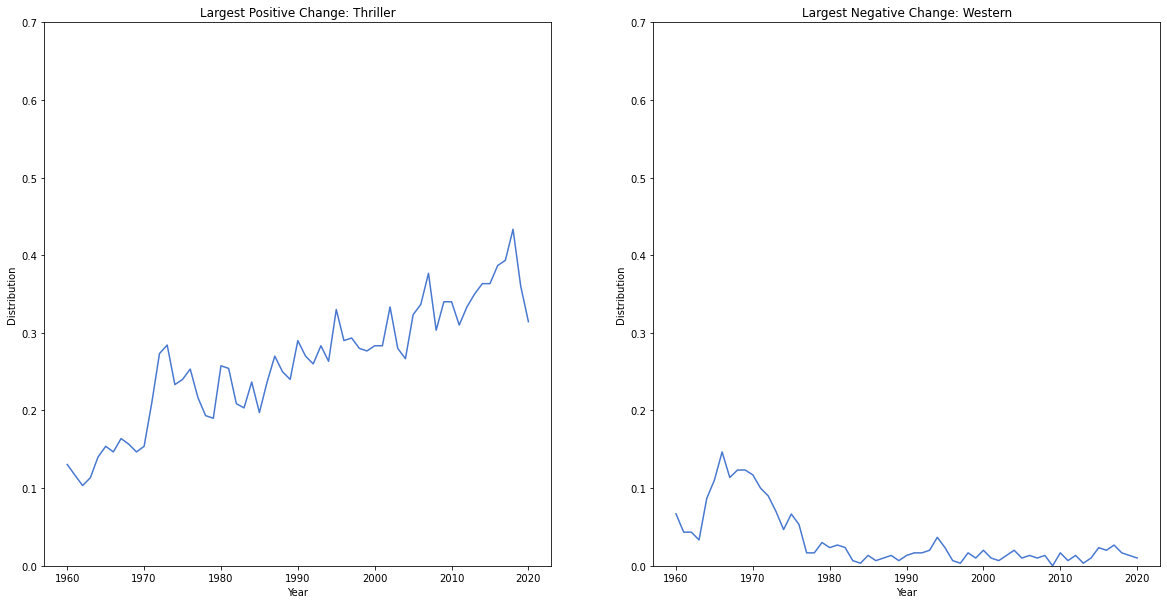

In [12]:
plot_top_worst_dist(_genre)

### Insights:

Y-axis represents the percentage of movies per year that contains the specified genre strain </br> For example- In 2020, roughly 30% of the top 300 movies(by popularity) contain the strain 'Thriller' in genre. In 1960, roughly 13% of the movies contain the strain 'Thriller'

>"When television became popular in the late 1940s and 1950s, TV westerns quickly became an audience favorite, with 30 such shows airing during prime-time in 1959. Traditional Westerns faded in popularity in the late 1960s..." -https://en.wikipedia.org/wiki/Westerns_on_television </br>

Western movies starts to lose popularity from the late 1960s



#### Assigning cleaned_gross to be the CLEANED imported dataframe with dummy genre variables

In [13]:
cleaned_gross = cleaned_gross_minus_budget(df)

iterating over 18288 rows


18288it [00:21, 834.83it/s]


done
dropped 11889 rows. final shape:  (6399, 32)


### _Creating a helper function to find the regression slope of Genre specific net income per year_

In [14]:
def find_linregress_slope_gross(dataframe):
    '''
    x = years, y = gross_minus_budget
    Returns a list of tuples of (slope, genre).
    ex: [(4428902,Thriller),(125214,Drama)...]
    '''
    m = genre_counter(dataframe)    # Similiar to previous function but returns slope instead of distribution.
    genre_category = list(m.keys())
    
    _albert = []                                                                               # Create empty list.
    for i in genre_category:                                                                   # Iterate through genres.
        _albert_yes = dataframe.loc[dataframe[i] == 1]
        _sample_df = _albert_yes.groupby(['year'])['gross_minus_budget'].mean().reset_index()  # Group by year and grab profit.
        _linregress = linregress(_sample_df['year'], _sample_df['gross_minus_budget'])[0]      # Grabs profit column for each genre.
        _albert.append((_linregress,i))                                                        # Append to list.
    
    _albert.sort(key = lambda x: x[0], reverse = True)
    return _albert

#### _Having a sorted list of slope and Genre Name will help us choose which Genres to plot_

In [15]:
gross_slope = find_linregress_slope_gross(cleaned_gross)

In [16]:
gross_slope

[(4428902.015937119, 'Animation'),
 (4392300.607497364, 'Musical'),
 (3905571.592722525, 'Adventure'),
 (3364200.4461238435, 'Fantasy'),
 (3304892.017566035, 'Sci-Fi'),
 (2689759.9678901974, 'Family'),
 (2357560.010897966, 'Action'),
 (1665891.8092986054, 'Music'),
 (1500153.499897386, 'Comedy'),
 (1364146.177246614, 'Mystery'),
 (1091141.068143111, 'Thriller'),
 (1021392.3278442412, 'War'),
 (975584.9045584837, 'Romance'),
 (880651.0098206727, 'Crime'),
 (870414.6509338834, 'History'),
 (718899.579357285, 'Horror'),
 (629027.9987008002, 'Drama'),
 (375519.70506954356, 'Western'),
 (183812.47464667558, 'Sport'),
 (76771.23079767724, 'Biography')]

##### Assigning a new column to the dataframe called 'year_bins' </br> 
If the year is between 1960-1969, assign 1960s...</br> If the year is between 1970-1979, assign 1970s..</br> If the year is between 1980-1989, assign 1980s...etc. </br>&emsp; until 6 TOTAL categories

In [17]:
albert_trimmed = cleaned_gross.copy()

In [18]:
cut_labels = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1950,1969,1979,1989,1999,2009,2025]
albert_trimmed['year_bins'] = pd.cut(albert_trimmed['year'], bins=cut_bins, labels=cut_labels)

#### Plotting Net Income over time; comparing Specific (Top) Genres vs Not

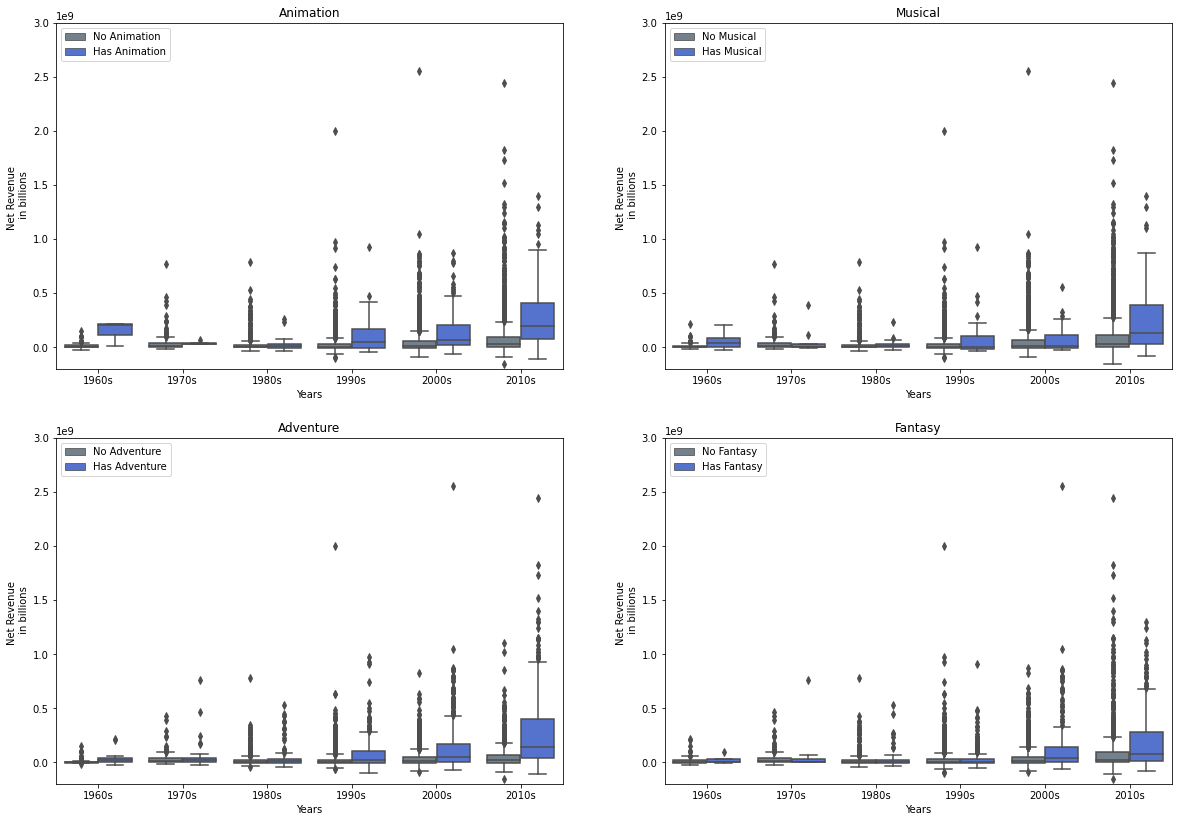

In [19]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,14))                  # Create figure with 2x2 subplots.

########## Upper Left ##########
ax_1 = axes[0][0]                                                          
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Animation', data = albert_trimmed, ax= ax_1, palette = ["slategray","royalblue"])

handles, _ = ax_1.get_legend_handles_labels()
ax_1.legend(loc='upper left',handles=handles,labels=["No Animation", "Has Animation"])              # Set legend location.
ax_1.set_ylabel('Net Revenue \n in billions')   # Set y-axis label.
ax_1.set_title(gross_slope[0][1])               # Set title.
ax_1.set_ylim(-200_000_000,3_000_000_000)       # Set range of y-axis.
ax_1.set_xlabel('Years')                        # Set x-axis label.

########## Upper Right ##########
ax_2 = axes[0][1]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Musical', data = albert_trimmed, ax= ax_2, palette = ["slategray","royalblue"])

handles, _ = ax_2.get_legend_handles_labels()
ax_2.legend(loc='upper left',handles = handles, labels=["No Musical", "Has Musical"])
ax_2.set_ylabel('Net Revenue \n in billions')   # Set y-axis label.
ax_2.set_title(gross_slope[1][1])               # Set title.
ax_2.set_ylim(-200_000_000,3_000_000_000)       # Set range of y-axis.
ax_2.set_xlabel('Years')                        # Set x-axis label.

########## Lower Left ##########
ax_3 = axes[1][0]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Adventure', data = albert_trimmed, ax= ax_3, palette = ["slategray","royalblue"])

handles, _ = ax_3.get_legend_handles_labels()
ax_3.legend(loc='upper left',handles = handles,labels=["No Adventure", "Has Adventure"])
ax_3.set_ylabel('Net Revenue \n in billions')   # Set y-axis label.
ax_3.set_title(gross_slope[2][1])               # Set title.
ax_3.set_ylim(-200_000_000,3_000_000_000)       # Set range of y-axis.
ax_3.set_xlabel('Years')                        # Set x-axis label.

########## Lower Right ##########
ax_4 = axes[1][1]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Fantasy', data = albert_trimmed, ax= ax_4, palette = ["slategray","royalblue"])

handles, _ = ax_4.get_legend_handles_labels()
ax_4.legend(loc='upper left',handles = handles,labels=["No Fantasy", "Has Fantasy"])
ax_4.set_ylabel('Net Revenue \n in billions')   # Set y-axis label.
ax_4.set_title(gross_slope[3][1])               # Set title.
ax_4.set_ylim(-200_000_000,3_000_000_000)       # Set range of y-axis.
ax_4.set_xlabel('Years');                       # Set x-axis label.

### Insights:

Movies that contain any of [Animation, Musical, Adventure, Fantasy], on average, have the greatest increase of net income over time. 

#### Plotting Net Income over time; comparing Specific (Bottom) Genres vs Not

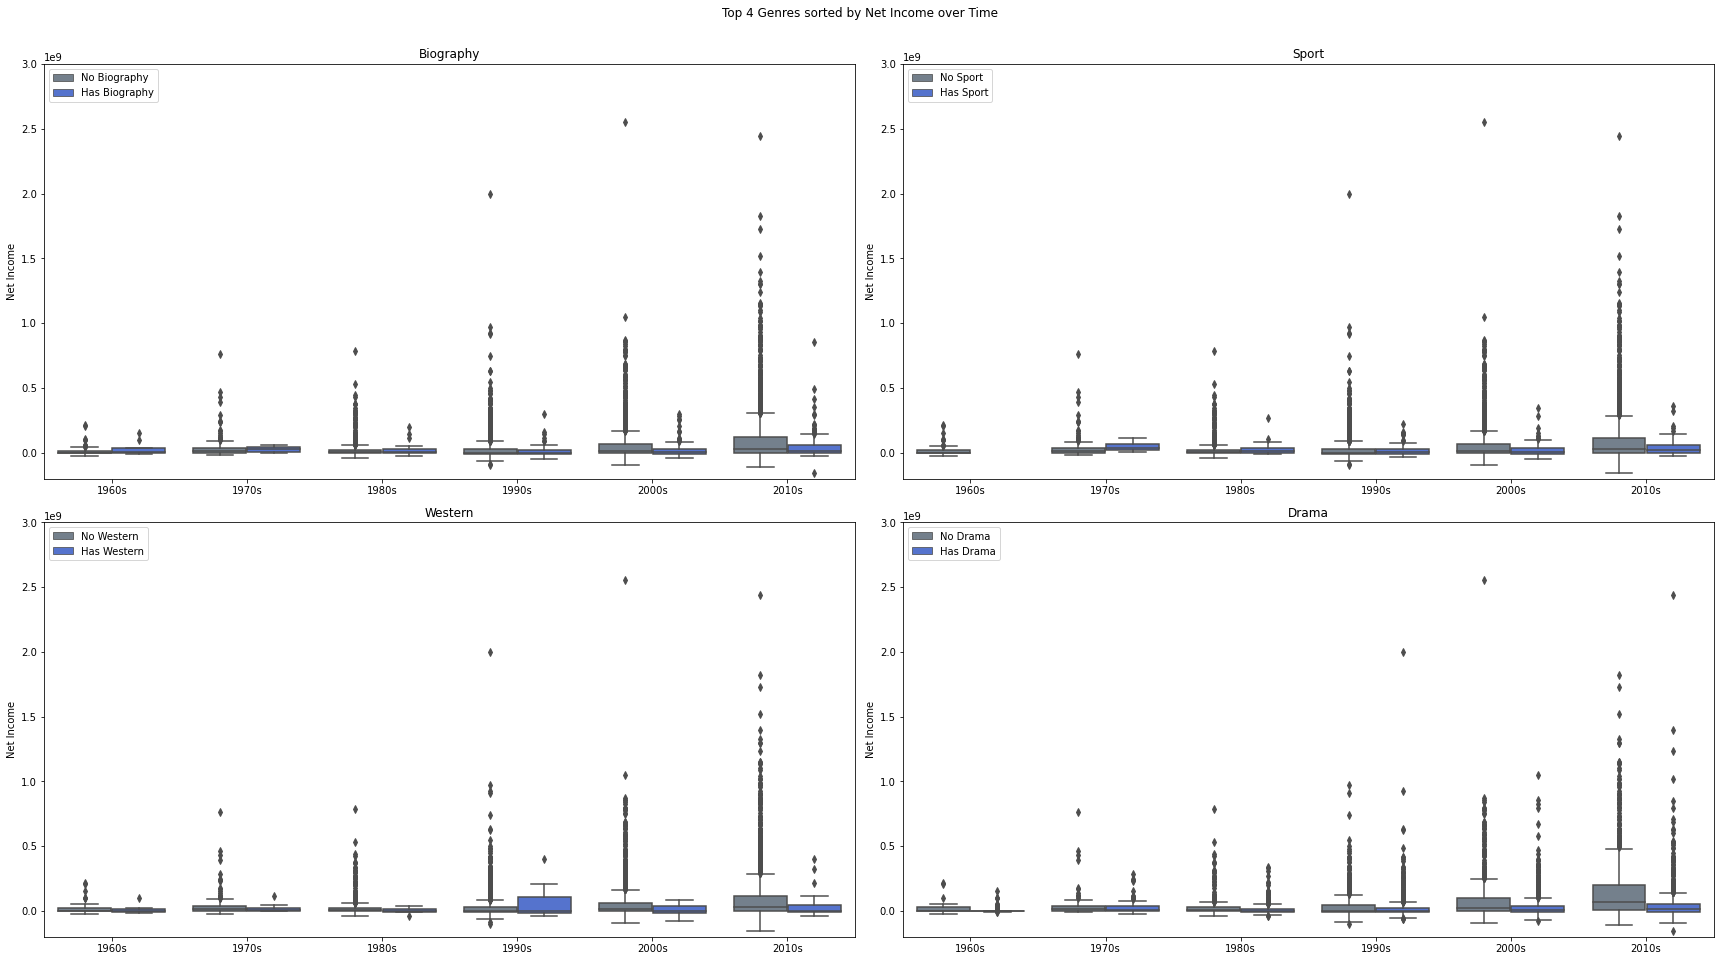

In [20]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(24,14))
ax_1 = axes[0][0]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Biography', data = albert_trimmed, ax= ax_1, palette=["slategray","royalblue"])
# new_labels = ["No Animation", "Has Animation"]
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
handles, _ = ax_1.get_legend_handles_labels()
ax_1.legend(loc='upper left',handles=handles,labels=["No Biography", "Has Biography"])
ax_1.set_ylabel('Net Income')
ax_1.set_title('Biography')
ax_1.set_ylim(-200_000_000,3_000_000_000)
ax_1.set_xlabel('')


ax_2 = axes[0][1]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Sport', data = albert_trimmed, ax= ax_2, palette = ["slategray","royalblue"])
handles, _ = ax_2.get_legend_handles_labels()
ax_2.legend(loc='upper left',handles = handles, labels=["No Sport", "Has Sport"])
# ax_2.legend(loc='upper left')
ax_2.set_ylabel('Net Income')
ax_2.set_title('Sport')
ax_2.set_ylim(-200_000_000,3_000_000_000)
ax_2.set_xlabel('')



ax_3 = axes[1][0]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Western', data = albert_trimmed, ax= ax_3, palette = ["slategray","royalblue"])
handles, _ = ax_3.get_legend_handles_labels()
ax_3.legend(loc='upper left',handles = handles,labels=["No Western", "Has Western"])
# ax_3.legend(loc='upper left')
ax_3.set_ylabel('Net Income')
ax_3.set_title('Western')
ax_3.set_ylim(-200_000_000,3_000_000_000)
ax_3.set_xlabel('')


ax_4 = axes[1][1]
sns.boxplot(x='year_bins',y='gross_minus_budget',hue='Drama', data = albert_trimmed, ax= ax_4, palette = ["slategray","royalblue"])
handles, _ = ax_4.get_legend_handles_labels()
ax_4.legend(loc='upper left',handles = handles,labels=["No Drama", "Has Drama"])
# ax_4.legend(loc='upper left')
ax_4.set_ylabel('Net Income')
ax_4.set_title('Drama')
ax_4.set_ylim(-200_000_000,3_000_000_000)

ax_4.set_xlabel('')
fig.suptitle('Top 4 Genres sorted by Net Income over Time')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Bottom 4 genres');

### Insights:

Movies that contain any of [Biography, Sport, Western, Drama], on average, have the least increase of net income over time.